# Step estimation for the Karlebachpark

All the steps in this notebook are essentially identical to `geb64.ipynb`. As such, additional explanations are only provided when necessary.

The goal of this notebook was the step estimation of a rectangular trajectory of the Karlebachpark, next to the university. The data was acquired using a different device and a much higher sampling frequency than the other track. As can be seen further below, the results are not very satisfactory. We are unsure if this is due to inaccuracies in the device, the processing not being able to handle higher frequencies, or the application being unaccurate.

In [1]:
import numpy as np
import pandas as pd
import utils
from scipy import signal 
from matplotlib import pyplot as plt
from preprocess_data import preprocess_data

In [2]:
#preprocess data
preprocess_data("data/karlebach/Accelerometer.csv", "data/karlebach/Gyroscope.csv")

In [3]:
#load preprocessed data for calibration
acc = np.load("preprocessed_data/karlebach_acc_all.npy")
print(acc.shape)

#compute sample frequency
recording_time = 305 #taken from meta data
samples = acc.shape[1]
f = samples/recording_time
print("Freq: " +  str(f))
#take the first 10 seconds of the accelerometer
acc = acc[:, :int(f *10)]
print(acc.shape)

(4, 125795)
Freq: 412.44262295081967
(4, 4124)


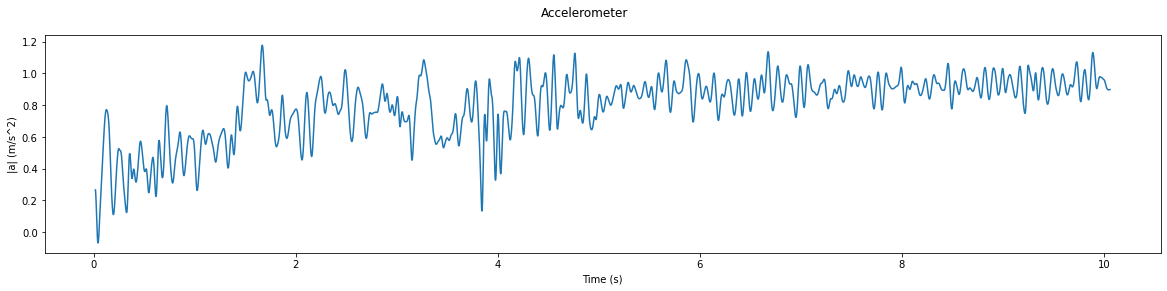

In [4]:

utils.plot_acc(acc, "norm")

In [5]:
#estiate g'b(0) by averaging over first ten seconds of accelerometer data
print(acc.shape)
grav = np.mean(acc, axis = 1)

gb_0 = grav[1:]
gb_0

(4, 4124)


array([0.80019899, 6.55358606, 7.35229171])

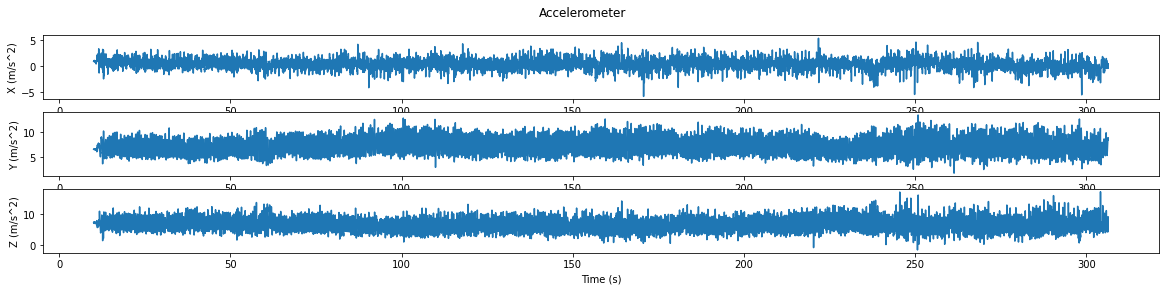

(4, 121671)

In [6]:
acc = np.load("preprocessed_data/karlebach_acc_all.npy")
acc = acc[:,int(f*10):]
utils.plot_acc(acc, "all")
acc.shape


In [7]:
#get g for entire time series
g_list = [gb_0]
sigma = 0.7
for t in range(1, acc.shape[1]):
    g_t = utils.get_gb(acc, t, sigma, g_list[-1])
    g_list.append(g_t)

g_array = np.asarray(g_list)
g_array.shape


(121671, 3)

In [8]:
# compute base shift matrix for entire series
R_list = []
for g in g_array:
    R_list.append(utils.get_matrix(g))

R_array = np.asarray(R_list)
R_array.shape

(121671, 3, 3)

In [9]:
# load gyro data 
gyro = np.load("preprocessed_data/karlebach_gyro_all.npy")
gyro = gyro[1:, int(f*10):].T
gyro.shape

(121671, 3)

In [10]:
# calcuate all turn rates
turn_rate_list = []
for t in range(gyro.shape[0]):
    turn_rate_list.append(R_array[t].T @ gyro[t])

turn_rate_array = np.asarray(turn_rate_list)
turn_rate_array.shape

(121671, 3)

In [11]:
# get turn angles
 

turn_angles = []

for t in range(turn_rate_array.shape[0]):
    turn_angles.append(turn_rate_array[:t].sum(axis = 0))



A bunch of different values for $\Delta_t$ have been tried in this step, but none yield any satisfactory results.

In [12]:
#because the previous step is computationally quite expensive, an extra cell to avoid recomputing the angles
delta_t = 0.012 #rougly 1/f = 0.0024; constant needs tweaking, as such not computed
turn_angle_array = np.asarray(turn_angles) * delta_t
turn_angle_array.shape

(121671, 3)

In [13]:
# get peaks from accelerometer

acc = np.load("preprocessed_data/karlebach_acc.npy")

acc = acc[:, int(f*10):]

# find peaks
peaks, _ = signal.find_peaks(acc[1], height=12, distance = 50)


In [14]:
step_size = 70

x = np.array([0])
y = np.array([0])

for peak in peaks:
    x = np.append(x, x[-1] + step_size * np.cos(turn_angle_array[peak]))
    y = np.append(y, y[-1] + step_size * np.sin(turn_angle_array[peak]))



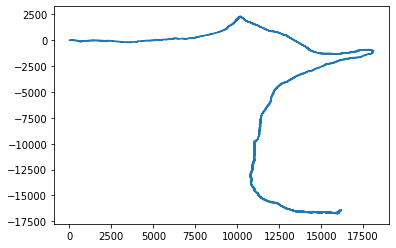

In [15]:
plt.plot(x,y)
plt.show()